<a href="https://colab.research.google.com/github/thanit456/NeuroSummary/blob/master/tf2_seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split


import pickle
import unicodedata
import re
import numpy as np
import os
import io
import time

In [0]:
!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf') # 3.2+
mpl.rc('font', family='TH Sarabun New')

plt.rcParams['font.family']='TH Sarabun New'  
%matplotlib inline

--2020-05-21 04:51:58--  https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf [following]
--2020-05-21 04:51:58--  https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98308 (96K) [application/octet-stream]
Saving to: ‘thsarabunnew-webfont.ttf’

thsarabunnew-webfon 100%[===================>]  96.00K  --.-KB/s    in 0.03s   

2020-05-21 04:51:59 (3.01 MB/s) - ‘thsara

# My own data preparation

In [0]:
with open('/content/drive/Shared drives/NeuroSummary/data/b_data_playground/thai_gov_split/train_v2.pkl', 'rb') as f:
  train_set = pickle.load(f)

with open('/content/drive/Shared drives/NeuroSummary/data/b_data_playground/thai_gov_split/val_v2.pkl', 'rb') as f:
  val_set = pickle.load(f)

with open('/content/drive/Shared drives/NeuroSummary/data/b_data_playground/thai_gov_split/test_v2.pkl', 'rb') as f:
  test_set = pickle.load(f)

In [0]:
train_set.head()

,content,headline,class
11629,"[กระทรวงทรัพยากรธรรมชาติ, และสิ่ง, แวดล้อม, โด...","[ทส., จัด, การ, ประชุม, การ, ลด, ปริมาณ, ขยะ, ...",ด้านความมั่นคง
8470,"[วัน, นี้, 28, มิถุนายน, 2560, เวลา, 11, ., 30...","[นายก, รัฐมนตรี, เผย, ต้องการ, ให้, การ, เปลี่...",ข่าวทำเนียบรัฐบาล
6389,"[เมื่อ, วัน, จันทร์, ที่, 9, กรกฎาคม, 2561, เว...","[ม.ล.ปนัดดาฯ, กล่าว, สุนทรพจน์, ใน, พิธี, เปิด...",ด้านกฎหมายฯ
1058,"[รอง, ปลัด, กระทรวงดิจิทัลฯ, นางวรรณพร เทพหัสด...","[รอง, ปลัด, กระทรวงดิจิทัลฯ, เปิด, งาน, การ, พ...",ด้านสังคม
6155,"[รัฐบาล, เร่งรัด, ขับ, เคลื่อน, งาน, สำคัญ, เพ...","[เร่ง, เดินหน้า, 5, โครงการ, ลด, ความ, เหลื่อม...",รายการวิทยุไทยคู่ฟ้า


In [0]:
## ! use only n first words for headline generation
def use_first_n_words(df_content, n, start_stop):
  new_ls = []
  for content in df_content:
    if start_stop:
      tmp = content[:n-2]
      tmp.insert(0, '<s>')
      tmp.append('</s>')
    else:
      tmp = content[:n]
    new_ls.append(tmp)
  return new_ls

# def use_first_n_words(df_content, n, start_stop=False):
#   new_ls = []
#   for content in df_content:
#     tmp = content[:n]
#     new_ls.append(tmp)
#   return new_ls

#define_n_first_words
n_first_content = 50
n_first_headline = 22

#trim sentence
words_train_contents = use_first_n_words(train_set['content'], n=n_first_content,start_stop=False)
words_train_headlines = use_first_n_words(train_set['headline'], n=n_first_headline,start_stop=True)
words_val_contents = use_first_n_words(val_set['content'], n=n_first_content, start_stop=False)
words_val_headlines = use_first_n_words(val_set['headline'], n=n_first_headline,start_stop=True)
words_test_contents = use_first_n_words(test_set['content'], n=n_first_content, start_stop=False)
words_test_headlines = use_first_n_words(test_set['headline'], n=n_first_headline, start_stop=True)
# words_val_headlines = use_first_n_words(val_set['headline'], n=n_first_headline,start_stop=False)
# words_test_contents = use_first_n_words(test_set['content'], n=n_first_content, start_stop=False)
# words_test_headlines = use_first_n_words(test_set['headline'], n=n_first_headline, start_stop=False)


# generate gold_sum
gold_sum_train = list(map(lambda x: " ".join(x),words_train_headlines))
gold_sum_val = list(map(lambda x: " ".join(x),words_val_headlines))
gold_sum_test = list(map(lambda x: " ".join(x),words_test_headlines))

In [0]:
import collections
def create_index(input_data,threshold):
    input_text = [data for data in input_data]
    # counts of word type has to be above or equal threshold
    words = [word for sublist in input_text for word in sublist]
    print("words :",words)
    word_count_all = list()
    word_count = list()
    #use set and len to get the number of unique words
    word_count_all.extend(collections.Counter(words).most_common(len(set(words))))
    unkcnt = 0
    for (word,cnt) in word_count_all:
      if cnt >= threshold:
        word_count.append((word,cnt))
      else:
        unkcnt+=cnt
    #include a token for unknown word
    word_count.append(("UNK",unkcnt))
    #print out 10 most frequent words
    # print("top 10: ",word_count[:10])
    # print("bottom 10: ",word_count[-10:])
    dictionary = dict()
    dictionary["for_keras_zero_padding"] = 0
    for word in word_count:
      dictionary[word[0]] = len(dictionary)
    # dictionary['<s>'] = len(dictionary) 
    # dictionary['</s>'] = len(dictionary)
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    
    return dictionary, reverse_dictionary
dict_t, rev_dict_t = create_index(input_data=words_train_contents+words_train_headlines,threshold=0)
# dict_t, rev_dict_t = create_index(input_data=words_train_contents,threshold=0)

# dict_stop_t, rev_dict_stop_t = create_index(input_data=words_70_train_stop_contents+words_20_train_stop_headlines,threshold=0)
print('Vocab size (Content): ',len(dict_t))
# print('Vocab stop ?size (Content): ',len(dict_stop_t))


words : 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
# with open('/content/drive/Shared drives/NeuroSummary/data/two_data_playground/dictionary/seq2seq_gru_additive/gru_dict.pkl', 'wb') as f:
#   pickle.dump(dict_t, f)
# with open('/content/drive/Shared drives/NeuroSummary/data/two_data_playground/dictionary/seq2seq_gru_additive/gru_rev_dict.pkl', 'wb') as f:
#   pickle.dump(rev_dict_t, f)

In [0]:
def convert(input_data,dictionary) :
  X = list()
  for data in input_data:
    sub_data = []
    for word in data:
      if word in dictionary:
        sub_data.append(dictionary[word])
      else:
        sub_data.append(dictionary["UNK"])
    X.append(sub_data)
  return np.array(X)

In [0]:
X_train = convert(words_train_contents,dict_t)
y_train = convert(words_train_headlines,dict_t)
X_val = convert(words_val_contents,dict_t)
y_val = convert(words_val_headlines,dict_t)
X_test = convert(words_test_contents,dict_t)
y_test = convert(words_test_headlines,dict_t)

In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen_input = 50
maxlen_output = 22

X_train = pad_sequences(X_train, maxlen=maxlen_input, padding='post')
y_train = pad_sequences(y_train, maxlen=maxlen_output, padding='post')
X_val = pad_sequences(X_val, maxlen=maxlen_input, padding='post')
y_val = pad_sequences(y_val, maxlen=maxlen_output, padding='post')
X_test = pad_sequences(X_test, maxlen=maxlen_input, padding='post')
y_test = pad_sequences(y_test, maxlen=maxlen_output, padding='post')

# TF 2.0 data preparation

In [0]:
BUFFER_SIZE = len(X_train)
BATCH_SIZE = 64
VAL_BATCH_SIZE = 64
VAL_BUFFER_SIZE = len(X_val)
steps_per_epoch = len(X_train)//BATCH_SIZE
val_steps_per_epoch = len(X_val)//VAL_BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(dict_t)
vocab_tar_size = len(dict_t)

dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [0]:
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).shuffle(VAL_BUFFER_SIZE)
val_dataset = val_dataset.batch(VAL_BATCH_SIZE, drop_remainder=True)

In [0]:
val_example_input_batch, val_example_target_batch = next(iter(val_dataset))
val_example_input_batch.shape, val_example_target_batch.shape

(TensorShape([64, 50]), TensorShape([64, 22]))

In [0]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 50]), TensorShape([64, 22]))

In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [0]:
print(vocab_inp_size)
print(embedding_dim)
print(units)
print(BATCH_SIZE)

25313
256
1024
64


In [0]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 50, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [0]:
# sample input
sample_hidden = encoder.initialize_hidden_state()
print(sample_hidden.shape)
print(example_input_batch.shape)

(64, 1024)
(64, 50)


# Additive attention

In [0]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [0]:
# class BahdanauAttention(tf.keras.layers.Layer):
#     def __init__(self, num_units):
#         super(BahdanauAttention, self).__init__()
#         self.W1 = tf.keras.layers.Dense(num_units)
#         self.W2 = tf.keras.layers.Dense(num_units)
#         self.V = tf.keras.layers.Dense(1)

#     def call(self, query, values):
#         # query is the decoder state at time step j
#         # query.shape: (batch_size, num_units)
#         # values are encoder states at every timestep i
#         # values.shape: (batch_size, num_timesteps, num_units)

#         # add time axis to query: (batch_size, 1, num_units)
#         query_with_time_axis = tf.expand_dims(query, axis=1)
#         # compute score:
#         score = self.V(tf.keras.activations.tanh(
#             self.W1(values) + self.W2(query_with_time_axis)))
#         # compute softmax
#         alignment = tf.nn.softmax(score, axis=1)
#         # compute attended output
#         context = tf.reduce_sum(
#             tf.linalg.matmul(
#                 tf.linalg.matrix_transpose(alignment),
#                 values
#             ), axis=1
#         )
#         context = tf.expand_dims(context, axis=1)
#         return context, alignment


In [0]:
attention_layer = BahdanauAttention(21)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 50, 1)


# Multiplicative attention

In [0]:
!pip install tensorflow-addons

In [0]:
import tensorflow_addons as tfa

In [0]:
# class LuongAttention(tf.keras.layers.Layer):
#     def __init__(self, num_units):
#         super(LuongAttention, self).__init__()
#         self.W = tf.keras.layers.Dense(num_units)

#     def call(self, query, values):
#         # add time axis to query
#         query_with_time_axis = tf.expand_dims(query, axis=1)
#         # compute score
#         score = tf.linalg.matmul(
#             query_with_time_axis, self.W(values), transpose_a=True)
#         # compute softmax
#         attention_weights = tf.nn.softmax(score, axis=1)
#         # compute attended output
#         context_vector = attention_weights * values
#         context_vector = tf.reduce_sum(context_vector, axis=1)
#         return context_vector, attention_weights
class LuongAttention(tf.keras.layers.Layer):
    def __init__(self, num_units):
        super(LuongAttention, self).__init__()
        self.W = tf.keras.layers.Dense(num_units)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # add time axis to query
        query_with_time_axis = tf.expand_dims(query, axis=1)
        # compute score
        score = tf.matmul(
            tf.transpose(query_with_time_axis), self.W(values)
        )
        
        # compute softmax
        alignment = tf.nn.softmax(score, axis=2)
        # compute attended output
        context = tf.matmul(alignment, values)
        return context, alignment

In [0]:
# a = tf.constant(np.arange(64*1024), shape=(64,1,1024))
# transposed_a = tf.transpose(a)
# b = tf.constant(np.arange(64*50*20), shape=(64, 50, 20))
# tf.matmul(transposed_a, b)

In [0]:
attention_layer = LuongAttention(20)
# attention_result, attention_weights = tfa.seq2seq.LuongAttention(1, sample_hidden, sample_output)
# attention_result, attention_weights = tfa.seq2seq.BahdanauAttention(1, sample_hidden, sample_output)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

tf.Tensor(
[[[0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]]], shape=(64, 1, 1024), dtype=float32)
tf.Tensor(
[[[-7.17063434e-04  1.62409421e-03 -2.61773239e-04 ... -1.49421534e-02
   -3.34295281e-03  1.14487382e-02]
  [-7.21063977e-03 -5.81972161e-03 -6.31409511e-03 ... -2.05455348e-02
   -2.05000560e-03  6.40905520e-04]
  [ 5.64627117e-03 -4.73918021e-03 -2.68094148e-03 ... -2.14975309e-02
    3.98038328e-03 -1.15925970e-03]
  ...
  [-1.53931626e-03  7.67851993e-03  6.64917473e-03 ...  5.87779377e-03
    8.39167100e-04 -5.31987706e-03]
  [ 1.12890517e-02 -9.44389205e-04 -9.04045301e-04 ...  5.83717134e-03
    1.97062409e-03 -1.83952767e-02]
  [ 7.90937524e-03  9.63620492e-04 -1.72815379e-03 ... -9.10516421e-04
    1.19058066e-03 -9.17660445e-03]]

 [[ 8.65265168e-03  6.07459852e-03  2.64923112e-03 ...  3.16177565e-03
    3.49644292e-03  1.53211877e-03]
  [-1.0757

InvalidArgumentError: ignored

# Decoding

In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for additive attention
    self.attention = BahdanauAttention(self.dec_units)
    
    # used for multiplicative attention
    # self.attention = LuongAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [0]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 25313)


In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [0]:
# checkpoint_dir = '/content/drive/Shared drives/NeuroSummary/checkpoint/seq2seq_gru_additive_teacher_forcing_v2'
checkpoint_dir = '/content/drive/Shared drives/NeuroSummary/checkpoint/seq2seq_gru_additive_scheduled_v2'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

# Teacher forcing

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([dict_t['<s>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):

      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

@tf.function
def val_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([dict_t['<s>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):

      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  return batch_loss


In [0]:
from tqdm import tqdm_notebook
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()


  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0
  val_total_loss = 0


  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):

    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 50 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  for (batch, (val_inp, val_targ)) in enumerate(val_dataset.take(val_steps_per_epoch)):
    val_batch_loss = val_step(val_inp, val_targ, enc_hidden)
    val_total_loss += val_batch_loss
  
  # saving (checkpoint) the model every 10 epochs
  if (epoch + 1) % 1 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch), end=', ')
  print('Val loss {:.4f}'.format(val_total_loss / val_steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 8.0651
Epoch 1 Batch 50 Loss 5.0778
Epoch 1 Batch 100 Loss 5.4042
Epoch 1 Batch 150 Loss 5.2119
Epoch 1 Loss 5.3894, Val loss 5.0852
Time taken for 1 epoch 94.33695602416992 sec

Epoch 2 Batch 0 Loss 5.3600
Epoch 2 Batch 50 Loss 4.7633
Epoch 2 Batch 100 Loss 4.8950
Epoch 2 Batch 150 Loss 4.6291
Epoch 2 Loss 4.7722, Val loss 4.5247
Time taken for 1 epoch 53.996204137802124 sec

Epoch 3 Batch 0 Loss 4.0716
Epoch 3 Batch 50 Loss 4.3674
Epoch 3 Batch 100 Loss 4.1488
Epoch 3 Batch 150 Loss 3.8562
Epoch 3 Loss 4.0934, Val loss 4.0009
Time taken for 1 epoch 54.344038009643555 sec

Epoch 4 Batch 0 Loss 3.6084
Epoch 4 Batch 50 Loss 3.6677
Epoch 4 Batch 100 Loss 3.6035
Epoch 4 Batch 150 Loss 3.3083
Epoch 4 Loss 3.5365, Val loss 3.7337
Time taken for 1 epoch 53.64350938796997 sec

Epoch 5 Batch 0 Loss 3.0440
Epoch 5 Batch 50 Loss 3.0202
Epoch 5 Batch 100 Loss 3.2369
Epoch 5 Batch 150 Loss 2.9608
Epoch 5 Loss 3.1408, Val loss 3.6279
Time taken for 1 epoch 53.80135750770569 sec

In [0]:
from tqdm import tqdm_notebook
INITIAL_EPOCH = 10
EPOCHS = 15

for epoch in range(EPOCHS):
  start = time.time()


  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0
  val_total_loss = 0


  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):

    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 50 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  for (batch, (val_inp, val_targ)) in enumerate(val_dataset.take(val_steps_per_epoch)):
    val_batch_loss = val_step(val_inp, val_targ, enc_hidden)
    val_total_loss += val_batch_loss
  
  # saving (checkpoint) the model every 10 epochs
  if (epoch + 1) % 1 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch), end=', ')
  print('Val loss {:.4f}'.format(val_total_loss / val_steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.5302
Epoch 1 Batch 50 Loss 1.6325
Epoch 1 Batch 100 Loss 1.7675
Epoch 1 Batch 150 Loss 1.6108
Epoch 1 Loss 1.6849, Val loss 3.5731
Time taken for 1 epoch 54.555976152420044 sec

Epoch 2 Batch 0 Loss 1.3882
Epoch 2 Batch 50 Loss 1.5733
Epoch 2 Batch 100 Loss 1.4389
Epoch 2 Batch 150 Loss 1.6034
Epoch 2 Loss 1.4760, Val loss 3.6284
Time taken for 1 epoch 54.39212512969971 sec

Epoch 3 Batch 0 Loss 1.1301
Epoch 3 Batch 50 Loss 1.0508
Epoch 3 Batch 100 Loss 1.1531
Epoch 3 Batch 150 Loss 1.2841
Epoch 3 Loss 1.2748, Val loss 3.7020
Time taken for 1 epoch 54.13847804069519 sec

Epoch 4 Batch 0 Loss 1.1317
Epoch 4 Batch 50 Loss 1.1055
Epoch 4 Batch 100 Loss 1.0166
Epoch 4 Batch 150 Loss 1.2660
Epoch 4 Loss 1.0870, Val loss 3.7780
Time taken for 1 epoch 53.798510789871216 sec

Epoch 5 Batch 0 Loss 0.8433
Epoch 5 Batch 50 Loss 0.9200
Epoch 5 Batch 100 Loss 0.9540
Epoch 5 Batch 150 Loss 1.0242
Epoch 5 Loss 0.9111, Val loss 3.8541
Time taken for 1 epoch 53.56099772453308 sec

# Scheduled sampling


In [0]:
@tf.function
def train_step(inp, targ, enc_hidden, it):
  loss = 0
  epsilon = 0.9999999
  k = 3
  c = 0.1


  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([dict_t['<s>']] * BATCH_SIZE, 1)

    eps = tf.math.maximum(epsilon, k-c*it)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):

      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      _x = tf.random.uniform(shape=[], minval=0,maxval=1)
      if _x < eps:
        # using teacher forcing
        dec_input = tf.expand_dims(targ[:, t], 1)
      else:
        # dont use teacher forcing
        # print(predictions)
        # print(tf.math.argmax(predictions, axis=1))
        dec_input = tf.cast(tf.expand_dims(tf.math.argmax(predictions, axis=1), 1), dtype=tf.int32)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

@tf.function
def val_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([dict_t['<s>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):

      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  return batch_loss


In [0]:
from tqdm import tqdm_notebook
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()


  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0
  val_total_loss = 0


  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):

    batch_loss = train_step(inp, targ, enc_hidden, epoch)
    total_loss += batch_loss

    if batch % 50 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  for (batch, (val_inp, val_targ)) in enumerate(val_dataset.take(val_steps_per_epoch)):
    val_batch_loss = val_step(val_inp, val_targ, enc_hidden)
    val_total_loss += val_batch_loss
    
  
  # saving (checkpoint) the model every 10 epochs
  if (epoch + 1) % 1 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch), end=', ')
  print('Val loss {:.4f}'.format(val_total_loss / val_steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 7.8780
Epoch 1 Batch 50 Loss 5.1970
Epoch 1 Batch 100 Loss 4.9083
Epoch 1 Batch 150 Loss 5.2637
Epoch 1 Loss 5.4086, Val loss 5.1159
Time taken for 1 epoch 100.53334522247314 sec

Epoch 2 Batch 0 Loss 5.0425
Epoch 2 Batch 50 Loss 5.0003
Epoch 2 Batch 100 Loss 5.0092
Epoch 2 Batch 150 Loss 4.9233
Epoch 2 Loss 4.7777, Val loss 4.5657
Time taken for 1 epoch 72.61401915550232 sec

Epoch 3 Batch 0 Loss 4.4000
Epoch 3 Batch 50 Loss 3.9984
Epoch 3 Batch 100 Loss 4.2950
Epoch 3 Batch 150 Loss 3.9079
Epoch 3 Loss 4.1861, Val loss 4.1462
Time taken for 1 epoch 72.43060111999512 sec

Epoch 4 Batch 0 Loss 3.7138
Epoch 4 Batch 50 Loss 3.5746
Epoch 4 Batch 100 Loss 3.8774
Epoch 4 Batch 150 Loss 3.7605
Epoch 4 Loss 3.7613, Val loss 3.9277
Time taken for 1 epoch 74.3675184249878 sec

Epoch 5 Batch 0 Loss 3.1640
Epoch 5 Batch 50 Loss 3.4662
Epoch 5 Batch 100 Loss 3.2167
Epoch 5 Batch 150 Loss 3.3937
Epoch 5 Loss 3.4426, Val loss 3.7726
Time taken for 1 epoch 75.61679553985596 sec



In [0]:
from tqdm import tqdm_notebook
INITIAL_EPOCH = 10
EPOCHS = 20

for epoch in range(INITIAL_EPOCH, EPOCHS):
  start = time.time()


  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0
  val_total_loss = 0


  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):

    batch_loss = train_step(inp, targ, enc_hidden, epoch)
    total_loss += batch_loss

    if batch % 50 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  for (batch, (val_inp, val_targ)) in enumerate(val_dataset.take(val_steps_per_epoch)):
    val_batch_loss = val_step(val_inp, val_targ, enc_hidden)
    val_total_loss += val_batch_loss
    
  
  # saving (checkpoint) the model every epochs
  if (epoch + 1) % 1 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch), end=', ')
  print('Val loss {:.4f}'.format(val_total_loss / val_steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 11 Batch 0 Loss 2.1112
Epoch 11 Batch 50 Loss 2.2165
Epoch 11 Batch 100 Loss 1.9869
Epoch 11 Batch 150 Loss 2.4663
Epoch 11 Loss 2.1818, Val loss 3.5631
Time taken for 1 epoch 69.56328654289246 sec

Epoch 12 Batch 0 Loss 2.0357
Epoch 12 Batch 50 Loss 2.1683
Epoch 12 Batch 100 Loss 2.0346
Epoch 12 Batch 150 Loss 2.0967
Epoch 12 Loss 2.0275, Val loss 3.5722
Time taken for 1 epoch 73.05270290374756 sec

Epoch 13 Batch 0 Loss 1.7976
Epoch 13 Batch 50 Loss 1.8571
Epoch 13 Batch 100 Loss 1.8191
Epoch 13 Batch 150 Loss 2.0240
Epoch 13 Loss 1.8785, Val loss 3.5863
Time taken for 1 epoch 72.75101017951965 sec

Epoch 14 Batch 0 Loss 1.6867
Epoch 14 Batch 50 Loss 1.7160
Epoch 14 Batch 100 Loss 1.7201
Epoch 14 Batch 150 Loss 1.7364
Epoch 14 Loss 1.7362, Val loss 3.6131
Time taken for 1 epoch 70.98681879043579 sec

Epoch 15 Batch 0 Loss 1.4626
Epoch 15 Batch 50 Loss 1.6035
Epoch 15 Batch 100 Loss 1.7036
Epoch 15 Batch 150 Loss 1.5490
Epoch 15 Loss 1.5998, Val loss 3.6551
Time taken for 1 epoc

In [0]:
from tqdm import tqdm_notebook
INITIAL_EPOCH = 20
EPOCHS = 40

for epoch in range(INITIAL_EPOCH, EPOCHS):
  start = time.time()


  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0
  val_total_loss = 0


  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):

    batch_loss = train_step(inp, targ, enc_hidden, epoch)
    total_loss += batch_loss

    if batch % 50 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  for (batch, (val_inp, val_targ)) in enumerate(val_dataset.take(val_steps_per_epoch)):
    val_batch_loss = val_step(val_inp, val_targ, enc_hidden)
    val_total_loss += val_batch_loss
    
  
  # saving (checkpoint) the model every epochs
  if (epoch + 1) % 1 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch), end=', ')
  print('Val loss {:.4f}'.format(val_total_loss / val_steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 21 Batch 0 Loss 0.8668
Epoch 21 Batch 50 Loss 0.8523
Epoch 21 Batch 100 Loss 0.9039
Epoch 21 Batch 150 Loss 0.7580
Epoch 21 Loss 0.8422, Val loss 3.9264
Time taken for 1 epoch 84.32172107696533 sec

Epoch 22 Batch 0 Loss 0.6782
Epoch 22 Batch 50 Loss 0.6382
Epoch 22 Batch 100 Loss 0.6597
Epoch 22 Batch 150 Loss 0.7107
Epoch 22 Loss 0.7260, Val loss 3.9761
Time taken for 1 epoch 71.97866463661194 sec

Epoch 23 Batch 0 Loss 0.6342
Epoch 23 Batch 50 Loss 0.5682
Epoch 23 Batch 100 Loss 0.5277
Epoch 23 Batch 150 Loss 0.7235
Epoch 23 Loss 0.6217, Val loss 4.0617
Time taken for 1 epoch 74.23924994468689 sec

Epoch 24 Batch 0 Loss 0.4734
Epoch 24 Batch 50 Loss 0.5441
Epoch 24 Batch 100 Loss 0.5544
Epoch 24 Batch 150 Loss 0.6479
Epoch 24 Loss 0.5251, Val loss 4.1134
Time taken for 1 epoch 74.15986752510071 sec

Epoch 25 Batch 0 Loss 0.4107
Epoch 25 Batch 50 Loss 0.4252
Epoch 25 Batch 100 Loss 0.4879
Epoch 25 Batch 150 Loss 0.5161
Epoch 25 Loss 0.4421, Val loss 4.1946
Time taken for 1 epoc

# Generation

In [0]:
def evaluate(sentence):
  attention_plot = np.zeros((maxlen_output, maxlen_input))

  inputs = sentence.reshape(1, maxlen_input)
  # sentence = preprocess_sentence(sentence)

  # inputs = [rev_dict_t[i] for i in sentence.split(' ')]
  # inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
  #                                                        maxlen=max_length_inp,
  #                                                        padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = '<s> '

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([dict_t['<s>']], 0)

  for t in range(maxlen_output):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += rev_dict_t[predicted_id] + ' '

    if rev_dict_t[predicted_id] == '</s>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
   
  plt.show()

In [0]:
import seaborn as sns
def index2sentence(indexes):
  result = ''
  for i, index in enumerate(indexes):
    result += rev_dict_t[index] + ' '

    if rev_dict_t[index] == '</s>':
      return result
    
  return result

def translate(sentence, plot=True):
  result, sentence, attention_plot = evaluate(sentence)

  if not plot:
    return result

  print('Input: %s' % (sentence))
  print('prediction : {}'.format(result))
  
  
  sentence = index2sentence(sentence)
  
  if plot:
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    # plot_attention(attention_plot, sentence.split(' '), result.split(' '))
    plt.figure(figsize=(20,10))
    sns.heatmap(attention_plot, yticklabels = result.split(' '), xticklabels = sentence.split(' '), linewidths=0.01)
    plt.show()

In [0]:
# restoring the latest checkpoint in checkpoint_dir
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
checkpoint.restore(os.path.join(checkpoint_dir, 'ckpt-40'))

In [0]:
X_test[0].shape

(50,)

In [0]:
print('headline : ',index2sentence(y_test[0]))
print('content  : ',index2sentence(X_test[0]))

headline :  <s> สคบ. ชี้แจง กรณี ผลิตภัณฑ์ เสริม อาหาร น้ำ UNK </s> 
content  :  เมื่อ วัน ที่ 7 ก.ย. 2561 พลตำรวจตรี ประสิทธิ์ เฉลิมวุฒิศักดิ์ เลขาธิการ คณะ กรรมการคุ้มครอง ผู้ บริโภค สำนักงานคณะกรรมการคุ้มครอง ผู้ บริโภค ชี้แจง ประเด็น ผลิตภัณฑ์ เสริม อาหาร น้ำ UNK UNK จาก กรณี UNK อายุ 56 ปี ชาว บ้าน UNK จ.ขอนแก่น ร้องเรียน ต่อ สื่อ มวล ชน เกี่ยว กับ ผลิตภัณฑ์ เสริม อาหาร น้ำ UNK ที่ มี พนักงาน ขาย นำ 


Input: [   62     8     2   232   532    25 11519   226    32  2419    10   578
  8225    10   578   166   319   405   727   389   121 25312 25312    41
   153 25312   673  2876    28   288   219 25312  2111  1040    96   347
   574   511   357    35   405   727   389   121 25312     2    19   867
   461    63]
prediction : <s> ผู้ ว่า ฯ เรื่อง ข้อ กล่าวหา การ ใช้ รถ โดยสาร ประจำทาง </s> 


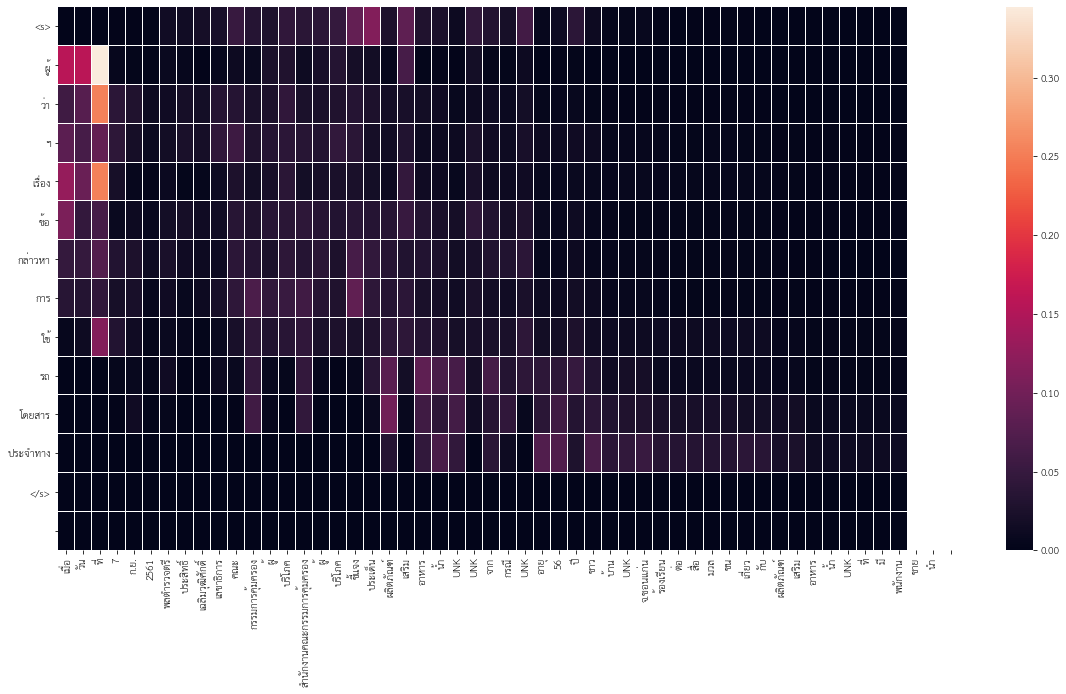

In [0]:
translate(X_test[0])

headline  :  <s> สคบ. ชี้แจง กรณี ผลิตภัณฑ์ เสริม อาหาร น้ำ UNK </s> 
content   :  เมื่อ วัน ที่ 7 ก.ย. 2561 พลตำรวจตรี ประสิทธิ์ เฉลิมวุฒิศักดิ์ เลขาธิการ คณะ กรรมการคุ้มครอง ผู้ บริโภค สำนักงานคณะกรรมการคุ้มครอง ผู้ บริโภค ชี้แจง ประเด็น ผลิตภัณฑ์ เสริม อาหาร น้ำ UNK UNK จาก กรณี UNK อายุ 56 ปี ชาว บ้าน UNK จ.ขอนแก่น ร้องเรียน ต่อ สื่อ มวล ชน เกี่ยว กับ ผลิตภัณฑ์ เสริม อาหาร น้ำ UNK ที่ มี พนักงาน ขาย นำ 
Input: [   62     8     2   232   532    25 11519   226    32  2419    10   578
  8225    10   578   166   319   405   727   389   121 25312 25312    41
   153 25312   673  2876    28   288   219 25312  2111  1040    96   347
   574   511   357    35   405   727   389   121 25312     2    19   867
   461    63]
prediction : <s> ผู้ ว่า ฯ เรื่อง ข้อ กล่าวหา การ ใช้ รถ โดยสาร ประจำทาง </s> 


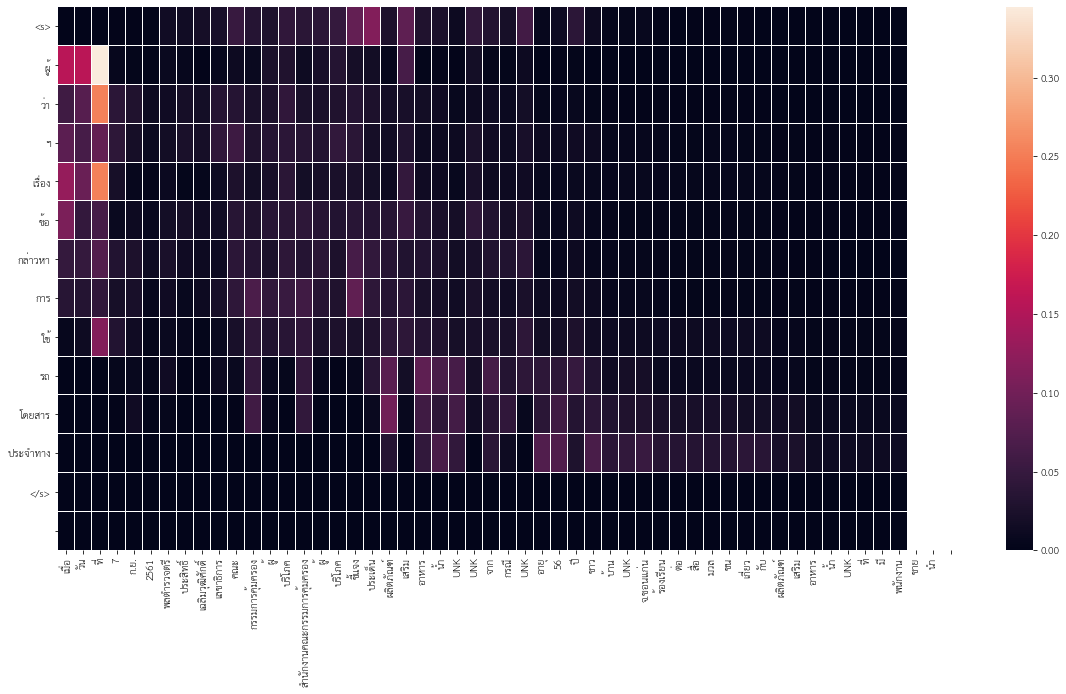

######################################################################################################################################################
headline  :  <s> ผู้ ตรวจ ราชการ กระทรวงอุตสาหกรรม ลง พื้นที่ ตรวจ ราชการ รอบ 2 ประจำ ปี งบ ประมาณ พ.ศ. 2561 ใน เขต พื้นที่ รับผิดชอบ </s> 
content   :  เมื่อ วัน ที่ 28 สิงหาคม 2561 นายจุลพงษ์ ทวีศรี โดย มี UNK UNK จังหวัดกำแพงเพชร พร้อม ด้วย เจ้าหน้าที่ อุตสาหกรรม จังหวัดกำแพงเพชร ให้ การ ต้อนรับ นอก จาก นี้ ยัง ได้ ลง พื้นที่ เพื่อ ตรวจ เยี่ยม โครงการ เสริมสร้าง เศรษฐกิจ ฐาน ชุมชน หรือ UNK UNK หมู่ บ้าน CIV กระทง เปลือก ข้าวโพด UNK ดอก ไม้ ตก UNK จ.กำแพงเพชร 
Input: [   62     8     2   376   243    25  1777    34    19 25312 25312  6129
    29    64   245   186  6129    12     1   248   353    41    17   377
    23    44    47    20    86   104    45   596    95   749   183   197
 25312 25312   533   219  1772  2011  1770  1393 25312   951   644   864
 25312  3301]
prediction : <s> รัฐมนตรี ประจำ พื้นที่ ตรวจ ราชการ กระทรวงอุตสาหกรรม

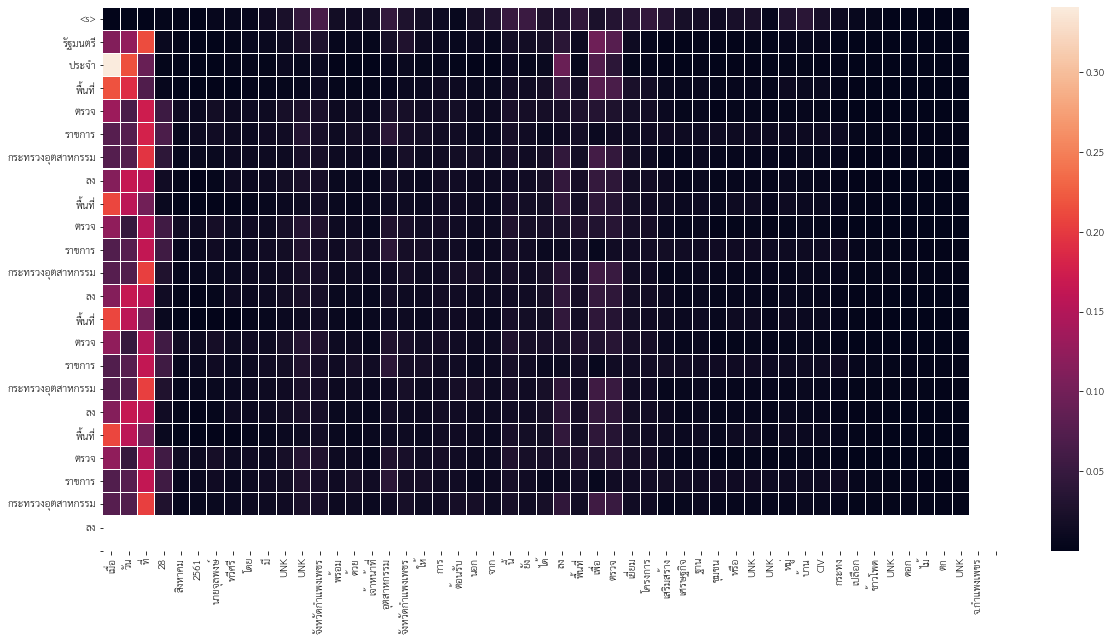

######################################################################################################################################################
headline  :  <s> รัฐบาล ยืนยัน ยัง ไม่ มี แนว คิด ปรับ ขึ้น ภาษี VAT วอน สังคม อย่า ตื่นตระหนก และ หลง เชื่อ ย้ำ นายก </s> 
content   :  วัน นี้ 25 พฤษภาคม 2561 พลโท สรรเสริญ แก้วกำเนิด โฆษก ประจำ สำนักนายกรัฐมนตรี กล่าว ถึง กรณี ที่ มี การ แชร์ ข้อความ และ ภาพ ระบุ UNK ประชาชน จ่าย ภาษี มูลค่า เพิ่ม เป็น 8 % ถ้า ไม่ ขึ้น ประเทศ จะ ล้มละลาย ใน ช่วง นี้ ว่า ข้อความ และ ภาพ ดัง กล่าว เป็น เรื่อง เก่า เมื่อ เดือน มี.ค. 
Input: [    8    17   390   308    25   991    99    50   215    87   110   153
     2    19     1  1637  1300     3   753   617 25312    53   543   354
   554   141     9   222   559  5475   118   127    65   178  1797     4
   246    17    42  1300     3   753   281    87     9   145  1388    62
   202   556]
prediction : <s> รัฐบาล แจง มือ มืด ปล่อย คลิป อ้าง เดินหน้า แก้ไข ปัญหา คน ไทย ชี้ 317 ปี ล่าสุด ดึง ราย ชื่อ เศรษ

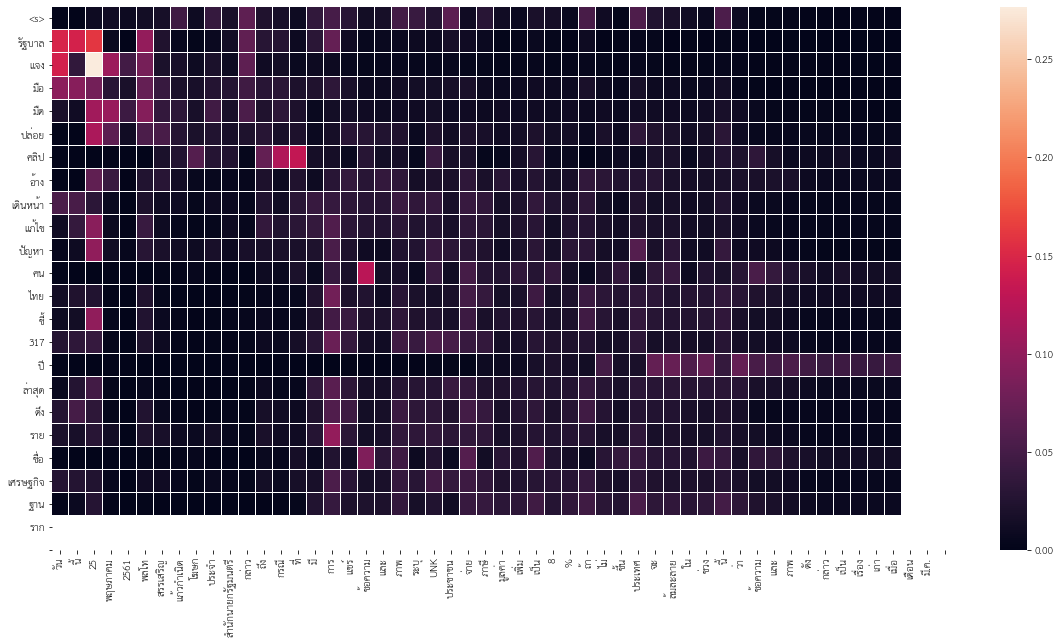

######################################################################################################################################################
headline  :  <s> นโยบาย การ ผลิต ครู ผู้ ช่วย เลือด ใหม่ </s> 
content   :  รัฐบาล เปิด โอกาส ให้ ผู้ มี ความ สามารถ ใน หลากหลาย สาขา อาชีพ สามารถ สอบ ครู ผู้ ช่วย ใน สาขา ที่ ขาดแคลน ได้ โดย จะ ฝึกอบรม อย่าง เข้มข้น ก่อน บรรจุ ต่อ จาก นี้ ไป ขอ เชิญ รับฟัง ไทย คู่ฟ้า ครับ จาก นโยบาย ของ รัฐบาล ที่ เปิด โอกาส ให้ ผู้ ไม่ มี 
Input: [  57   38  136   12   10   19   11  302    4 1633  768  488  302 1162
  391   10   58    4  768    2 1863   23   34  178  639   76 1829  404
 1263   96   41   17   90  157  388  270   36  590  449   41   98   18
   57    2   38  136   12   10  118   19]
prediction : <s> รัฐบาล เชิญชวน ประชาชน รับ ทราบ ความ พร้อม เป็น เจ้าภาพ จัด การ เปิด งาน เลี้ยง รับรอง มาตรฐาน แรงงาน นอก ระบบ การ เป็น ครัว 


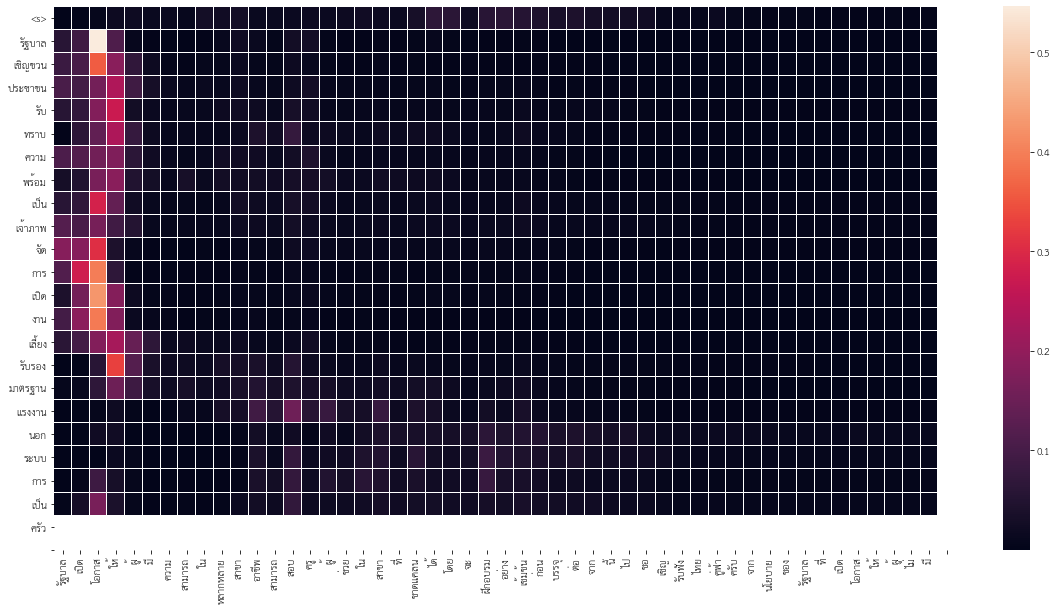

######################################################################################################################################################
headline  :  <s> ปิด งาน ชุมนุม ลูก เสือ จังหวัด ชาย แดน ภาค ใต้ ครั้ง ที่ 12 จังหวัดสตูล </s> 
content   :  พล.อ.สุรเชษฐ์ ชัยวงศ์ รัฐมนตรี ช่วย ว่าการ กระทรวงศึกษาธิการ เป็น ประธาน พิธี ปิด งาน ชุมนุม ลูก เสือ จังหวัด ชาย แดน ภาค ใต้ ครั้ง ที่ 12 ณ ค่าย ลูกเสือปากบาง อำเภอละงู จังหวัดสตูล พล.อ.สุรเชษฐ์ ชัยวงศ์ รมช. ศึกษาธิการ ได้ กล่าว ใน พิธี ปิด ดัง นี้ ท่าน ผู้ บังคับบัญชา ลูกเสือ ลูกเสือ - UNK ที่ เข้า ร่วม ชุมนุม คณะ ลูกเสือ จาก 
Input: [  585     7    58    22   103     9    21    82   626    13  1724   828
  3510   158   271   430    51   109    54     2   264    26  1564 20511
  7945  3491   585   480   884    23    87     4    82   626   281    17
   800    10  3709  2066  2066    39 25312     2    46    27  1724    32
  2066    41]
prediction : <s> สุรเชษฐ์ ประชุม เตรียม งาน ชุมนุม ลูก เสือ จังหวัด ชาย แดน ภาค ใต้ ครั้ง ที่ 12

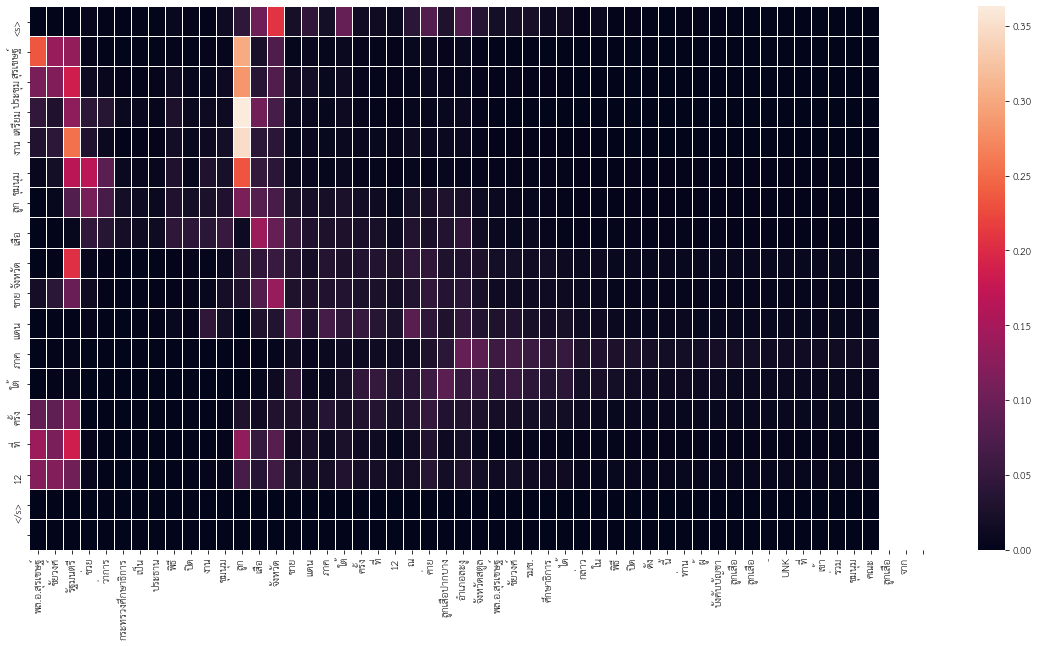

######################################################################################################################################################
headline  :  <s> เตือน นาย จ้าง ห้าม บังคับ ลูกจ้าง ทำ งาน วัน หยุด </s> 
content   :  กรมสวัสดิการ และ คุ้มครอง แรงงาน เตือน นาย จ้าง ให้ ลูกจ้าง ทำ งาน ใน วัน หยุด ผิด กฎหมาย หาก จำเป็น ต้อง ได้ รับ ความ ยินยอม จาก ลูกจ้าง ก่อน และ ต้อง จ่าย ค่า ทำ งาน ใน วัน หยุด นายอนันต์ชัย อุทัยพัฒนา ชีพ อธิบดี กรมสวัสดิการ และ คุ้มครอง แรงงาน กสร. เปิดเผย ว่า พระราชบัญญัติ คุ้มครอง แรงงาน พ.ศ. 2541 
Input: [  481     3   251    88   484   384   330    12   512    79    13     4
     8  1038   418   199   744  1188   265    23    48    11  8692    41
   512   404     3   265   543   237    79    13     4     8  1038   863
   566   190   481     3   251    88   518    67    42   705   251    88
   212 10437]
prediction : <s> กสร. เตือน ภัย อย่า ลง เชื่อ เพจ หลอก ให้ ลูกจ้าง ทำ งาน กระทบ การ จ่าย ค่า จ้าง </s> 


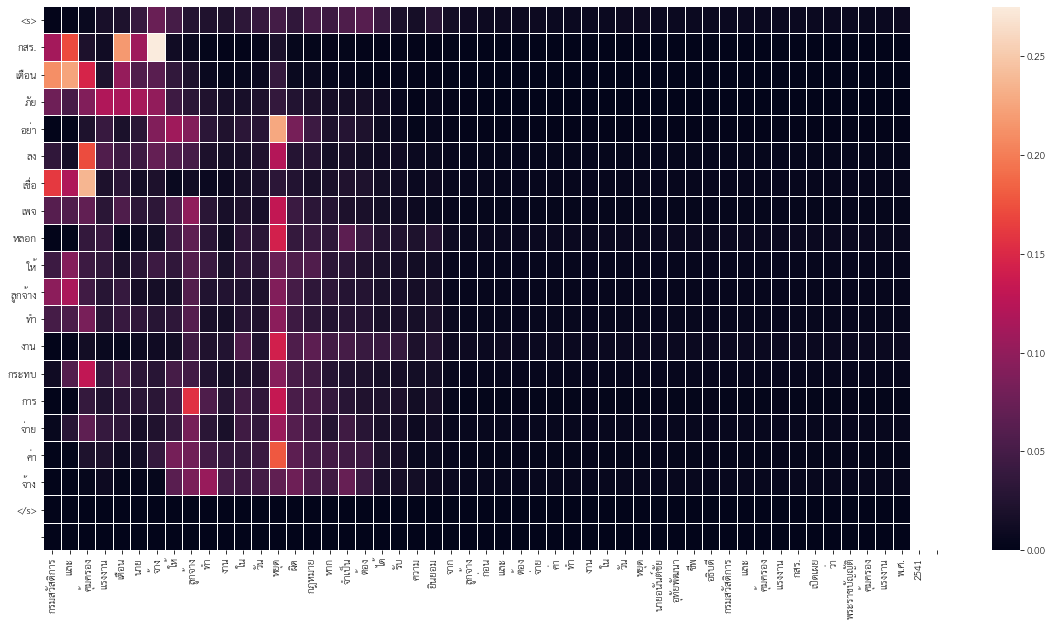

######################################################################################################################################################
headline  :  <s> ฐานะ การ คลัง ของ รัฐบาล ใน ช่วง 8 เดือน แรก ของ ปี งบ ประมาณ 2560 </s> 
content   :  UNK สํานัก งาน เศรษฐกิจการ คลัง ใน ฐานะ โฆษก กระทรวงการคลัง แถลง ข่าว ฐานะ การ คลัง ของ รัฐบาล ตาม ระบบ กระแส เงิน สด ใน ช่วง 8 เดือน แรก ของ ปี งบ ประมาณ 2560 เดือน ตุลาคม 2559 – เดือน พฤษภาคม 2560 นายกฤษฎา  จี นะ วิจารณะ UNK  อํานวยการ สํานัก งาน เศรษฐกิจการ คลัง ใน ฐานะ 
Input: [25312  5540    13  1608   415     4   262    99   286   207   179   262
     1   415    18    57    55   113  1127    74   940     4   246   222
   202   363    18    28   240   221    31   202   266   256   227   202
   308    31  5893  3581  1378 25312  4671  5539  5540    13  1608   415
     4   262]
prediction : <s> ผล การ จัด มหกรรม วัน ที่ 1 ปี 2560 </s> 


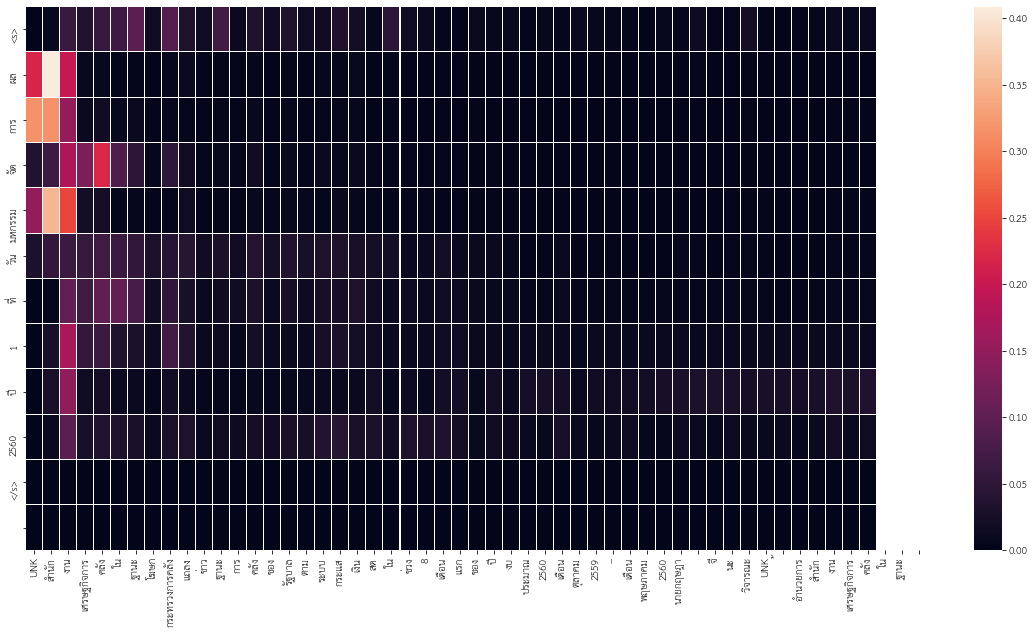

######################################################################################################################################################
headline  :  <s> พม. กำชับ ทีม One Home เร่ง เยียวยา จิตใจ สาว UNK วัย 15 ปี ที่ ถูก ลุง เขย บังคับ ข่มขืน จน </s> 
content   :  วัน นี้ 12 ม.ค. 61 เวลา 08 . 30 น. กระทรวงการพัฒนาสังคมและความมั่นคงของมนุษย์ พม. โดย นายณรงค์ คงคำ รอง ปลัด กระทรวงการพัฒนาสังคมและความมั่นคงของมนุษย์ รอง ปลัด พม. เป็น ประธาน การ ประชุม ศูนย์ ปฏิบัติการ กระทรวงการพัฒนาสังคมและความมั่นคงของมนุษย์ ศปก.พม. ครั้ง ที่ 20 / 2561 เพื่อ รับ ทราบ ปัญหา ทาง สังคม ต่างๆ ที่ เกิด ขึ้น ใน แต่ละ วัน และ ร่วมหา แนวทาง การ 
Input: [   8   17  264  623  130   24  373   14   66   33  132   97   34  605
   30   37  132   30   37   97    9   21    1   15  151  257  132  730
   54    2  205   68   25   20   48  380   85   52  106  757    2  241
  127    4  792    8    3 1286  180    1]
prediction : <s> พม. กำชับ ทีม One Home เร่ง ช่วยเหลือ พร้อม เยียวยา จิตใจ เด็ก หญิง วัย 12 ปี 

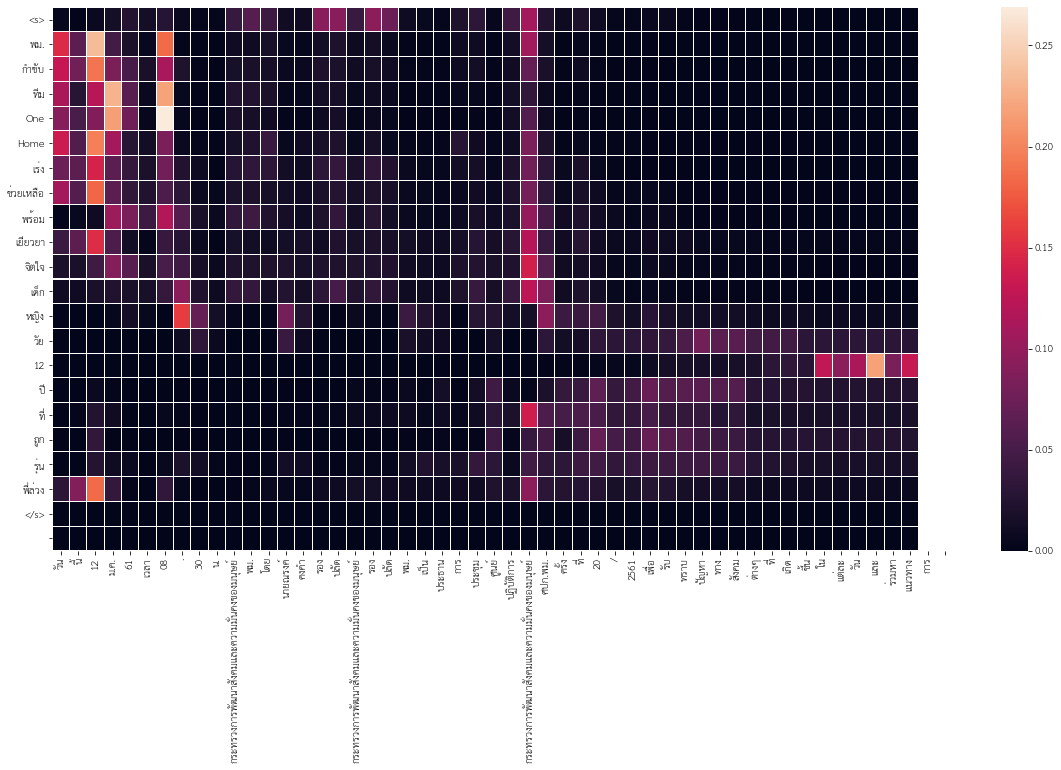

######################################################################################################################################################
headline  :  <s> นรม. เชิญชวน ประชาชน ร่วม กิจกรรม สัปดาห์ เผยแผ่ พระพุทธศาสนา เนื่อง ใน เทศกาล วัน มา ฆบูชา ประจำ ปี 2561 ณ พุทธมณฑล 25 </s> 
content   :  ก่อน การ ประชุม คณะ รัฐมนตรี นายสุวพันธุ์ ตันยุวรรธนะ รมต. นร. ได้ เข้า พบ นายก รัฐมนตรี เพื่อ ประชาสัมพันธ์ ใน การ จัด สัปดาห์ เผยแผ่ พระพุทธศาสนา เนื่อง ใน เทศกาล วัน มาฆบูชา พร้อม ย้ำ ให้ ยึด หลัก คำ สอน ของ พระพุทธเจ้า ใน การ ดำเนิน ชีวิต ประจำ วัน วัน นี้ 20 กุมภาพันธ์ 2561 เวลา 08 . 30 
Input: [ 404    1   15   32    7  857  698 1457   23   46  250   16    7   20
  731    4    1   43  950 4884 1624  214    4  479    8 2754   29  213
   12  858  292  398 1335   18 6779    4    1   77  193   50    8    8
   17  205  282   25   24  373   14   66]
prediction : <s> นายก รัฐมนตรี เป็น ประธาน การ ประชุม คณะ รัฐมนตรี 7 หน่วย งาน ใน โอกาส เข้า รับ ตำแหน่ง วัน งด สูบ บุหรี่ โลก ก่อน 


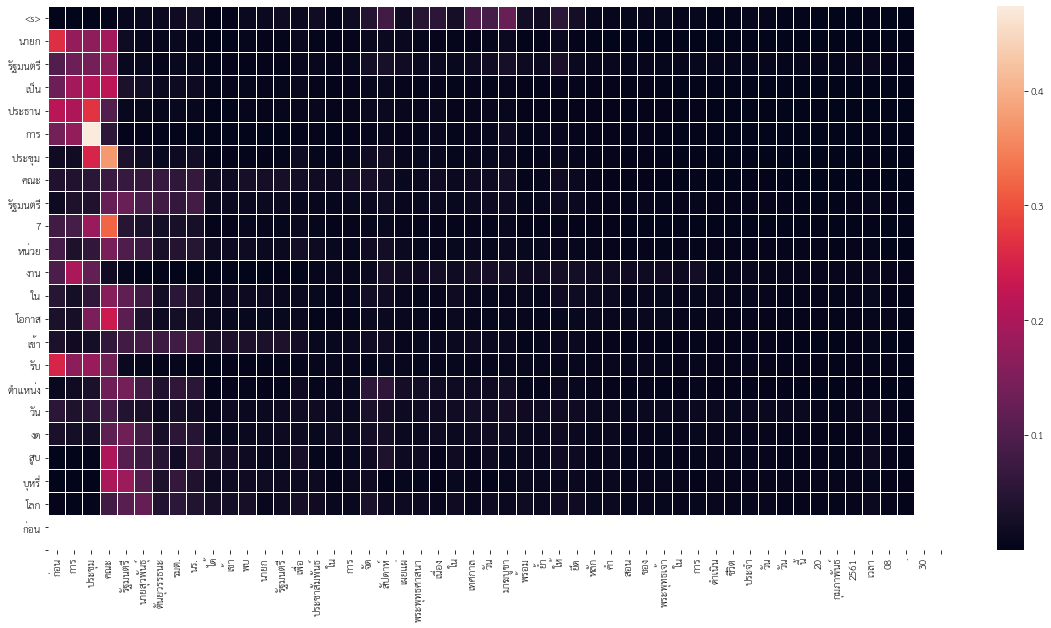

######################################################################################################################################################
headline  :  <s> ไทย และ UNK เจตนารมณ์ ร่วม กัน ใน การ แก้ไข ปัญหา ยา เสพ ติด อาชญากรรม และ การ ทุจริต </s> 
content   :  วัน นี้ วัน จันทร์ ที่ 5 มีนาคม 2561 เวลา 13 . 15 น. นายยูริ เฟโดทอฟ UNK Fedotov ผู้ อำนวย การ บริหาร UNK ด้วย ยา เสพ ติด และ UNK UNODC และ รอง เลขาธิการ สหประชาชาติ เข้า เยี่ยม คารวะ พลอากาศ เอก  ประจิน จั่นตอง รอง นายก รัฐมนตรี และ รัฐมนตรี ว่าการ กระทรวงยุติธรรม ณ ห้อง รับรอง 1 ตึกบัญชา 
Input: [    8    17     8   507     2   117   236    25    24   134    14   163
    33  6589 25312  8200    10   167     1    89 25312    64   394   622
   385     3 25312  4235     3    30   226  1848    46   104   295   591
   361   477    30    16     7     3     7    22    70    26    75   471
    49   555]
prediction : <s> รอง นายก รัฐมนตรี และ รัฐมนตรี ว่าการ กระทรวงกลาโหม สาธารณรัฐอินเดีย และ รอง นายก รัฐมนตรี และ รัฐมนตรี ว

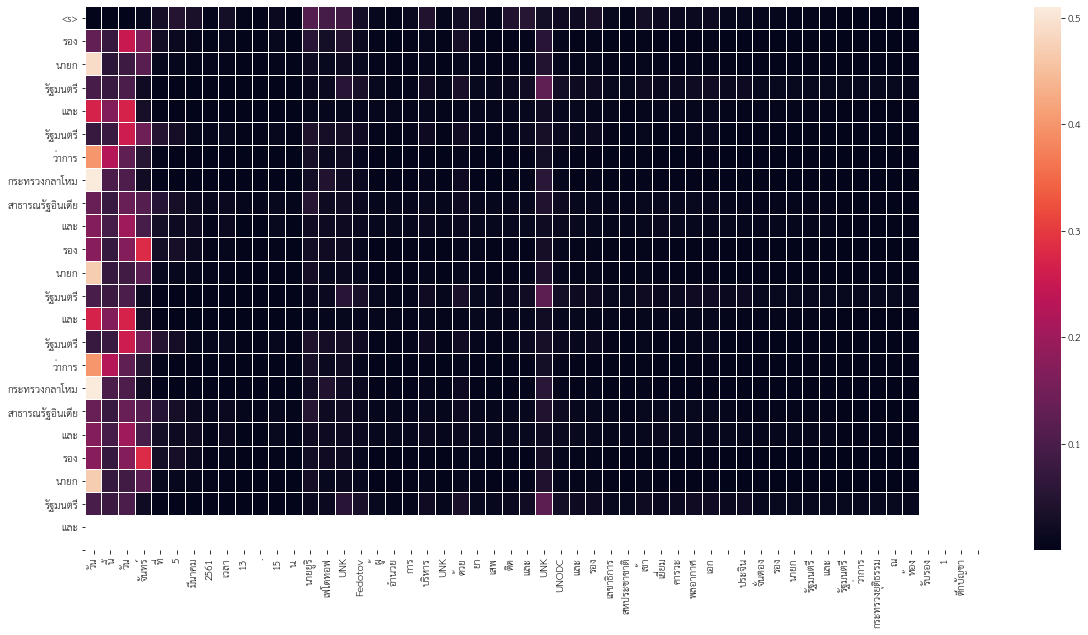

######################################################################################################################################################


In [0]:
for i in range(10):
  print('headline  : ',index2sentence(y_test[i]))
  print('content   : ',index2sentence(X_test[i]))
  translate(X_test[i])
  print( '#' * 150)

In [0]:
encoder.summary()

Model: "encoder_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      multiple                  6480128   
_________________________________________________________________
gru_4 (GRU)                  multiple                  3938304   
Total params: 10,418,432
Trainable params: 10,418,432
Non-trainable params: 0
_________________________________________________________________


In [0]:
decoder.summary()

Model: "decoder_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      multiple                  6480128   
_________________________________________________________________
gru_5 (GRU)                  multiple                  7084032   
_________________________________________________________________
dense_20 (Dense)             multiple                  25945825  
_________________________________________________________________
bahdanau_attention_6 (Bahdan multiple                  2100225   
Total params: 41,610,210
Trainable params: 41,610,210
Non-trainable params: 0
_________________________________________________________________


# Evaluation

In [0]:
!pip install rouge

In [0]:
# additive + scheduled sampling with stopwords v2
# v2 + fixed vocab @ checkpoint-25 to see result
from tqdm import tqdm_notebook
from rouge import Rouge
def inference(dataset) :
  pred_sum = []
  for c in tqdm_notebook(dataset):
    pred_sum.append(translate(c, plot=False))
  return pred_sum
def evaluate_result(gold_sum,pred_sum) : 
  rouge = Rouge()
  avg_scores = rouge.get_scores(pred_sum, gold_sum, avg=True)
  return avg_scores 

y_train_pred = inference(X_train)
y_val_pred = inference(X_val)
y_test_pred = inference(X_test)

print('Eval train :', evaluate_result(gold_sum_train, y_train_pred))
print('Eval val   :', evaluate_result(gold_sum_val, y_val_pred))
print('Eval test  :', evaluate_result(gold_sum_test, y_test_pred))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys



Eval train : {'rouge-1': {'f': 0.9438678720831742, 'p': 0.9549408554315265, 'r': 0.9390878225425167}, 'rouge-2': {'f': 0.9297755438920957, 'p': 0.9400960246733056, 'r': 0.9253951117545213}, 'rouge-l': {'f': 0.9499689347419972, 'p': 0.966245063470805, 'r': 0.9408460446305874}}
Eval val   : {'rouge-1': {'f': 0.30696986904541884, 'p': 0.3441157267098016, 'r': 0.295776334679094}, 'rouge-2': {'f': 0.13969712443591825, 'p': 0.1524255401047246, 'r': 0.13624046482582075}, 'rouge-l': {'f': 0.3150038260504538, 'p': 0.36395123771687127, 'r': 0.29421264574014744}}
Eval test  : {'rouge-1': {'f': 0.30774954594178605, 'p': 0.34410322336521426, 'r': 0.29772220776952013}, 'rouge-2': {'f': 0.14070226601997562, 'p': 0.15239995024524688, 'r': 0.13821015598564737}, 'rouge-l': {'f': 0.31534850091930056, 'p': 0.3630970526742413, 'r': 0.29580947145323233}}


# Result

In [0]:
# additive + scheduled sampling with stopwords v2
# v2 + fixed vocab @ checkpoint-25 to see result
from tqdm import tqdm_notebook
from rouge import Rouge
def inference(dataset) :
  pred_sum = []
  for c in tqdm_notebook(dataset):
    pred_sum.append(translate(c, plot=False))
  return pred_sum
def evaluate_result(gold_sum,pred_sum) : 
  rouge = Rouge()
  avg_scores = rouge.get_scores(pred_sum, gold_sum, avg=True)
  return avg_scores 

y_train_pred = inference(X_train)
y_val_pred = inference(X_val)
y_test_pred = inference(X_test)

print('Eval train :', evaluate_result(gold_sum_train, y_train_pred))
print('Eval val   :', evaluate_result(gold_sum_val, y_val_pred))
print('Eval test  :', evaluate_result(gold_sum_test, y_test_pred))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys



Eval train : {'rouge-1': {'f': 0.7548389208837086, 'p': 0.7912428118627294, 'r': 0.7387089023635651}, 'rouge-2': {'f': 0.689113277674863, 'p': 0.7185561387691819, 'r': 0.6766853387906568}, 'rouge-l': {'f': 0.7690897317922787, 'p': 0.8198946858836164, 'r': 0.7410594341653409}}
Eval val   : {'rouge-1': {'f': 0.30578730783123675, 'p': 0.3446574229487299, 'r': 0.2935064517849565}, 'rouge-2': {'f': 0.13657465220793744, 'p': 0.15019344853906752, 'r': 0.13243244237960503}, 'rouge-l': {'f': 0.31221659171383526, 'p': 0.36183328120131214, 'r': 0.291603488904633}}
Eval test  : {'rouge-1': {'f': 0.3034180407678131, 'p': 0.3391320342893865, 'r': 0.29314421520162287}, 'rouge-2': {'f': 0.1363159418994327, 'p': 0.14849590525579986, 'r': 0.13323571023988423}, 'rouge-l': {'f': 0.31060185372678223, 'p': 0.3562275440146554, 'r': 0.29203362116465936}}


In [0]:
# additive + scheduled sampling with stopwords v2
# v2 + fixed vocab @ checkpoint-20 to see result
from tqdm import tqdm_notebook
from rouge import Rouge
def inference(dataset) :
  pred_sum = []
  for c in tqdm_notebook(dataset):
    pred_sum.append(translate(c, plot=False))
  return pred_sum
def evaluate_result(gold_sum,pred_sum) : 
  rouge = Rouge()
  avg_scores = rouge.get_scores(pred_sum, gold_sum, avg=True)
  return avg_scores 

y_train_pred = inference(X_train)
y_val_pred = inference(X_val)
y_test_pred = inference(X_test)

print('Eval train :', evaluate_result(gold_sum_train, y_train_pred))
print('Eval val   :', evaluate_result(gold_sum_val, y_val_pred))
print('Eval test  :', evaluate_result(gold_sum_test, y_test_pred))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys



Eval train : {'rouge-1': {'f': 0.5304172703267782, 'p': 0.5993890530213747, 'r': 0.4984496871399446}, 'rouge-2': {'f': 0.39853716822806046, 'p': 0.4471655350479614, 'r': 0.3769511685806194}, 'rouge-l': {'f': 0.5418479574877827, 'p': 0.6221696013583277, 'r': 0.5005365522888521}}
Eval val   : {'rouge-1': {'f': 0.3049746348456849, 'p': 0.35455041626939415, 'r': 0.28559127506638454}, 'rouge-2': {'f': 0.12922987608705377, 'p': 0.14607809584916812, 'r': 0.12252981797811215}, 'rouge-l': {'f': 0.31002063738237773, 'p': 0.36605344676931884, 'r': 0.28507264865247467}}
Eval test  : {'rouge-1': {'f': 0.303334813912574, 'p': 0.35050080812414547, 'r': 0.2852018591213316}, 'rouge-2': {'f': 0.13023211436431348, 'p': 0.14632215453052758, 'r': 0.1240777651436665}, 'rouge-l': {'f': 0.3093743308520958, 'p': 0.3638490294407184, 'r': 0.28545016797108613}}


In [0]:
# additive + scheduled sampling with stopwords v2
# v2 + fixed vocab @ checkpoint-15 to see result
from tqdm import tqdm_notebook
from rouge import Rouge
def inference(dataset) :
  pred_sum = []
  for c in tqdm_notebook(dataset):
    pred_sum.append(translate(c, plot=False))
  return pred_sum
def evaluate_result(gold_sum,pred_sum) : 
  rouge = Rouge()
  avg_scores = rouge.get_scores(pred_sum, gold_sum, avg=True)
  return avg_scores 

y_train_pred = inference(X_train)
y_val_pred = inference(X_val)
y_test_pred = inference(X_test)

print('Eval train :', evaluate_result(gold_sum_train, y_train_pred))
print('Eval val   :', evaluate_result(gold_sum_val, y_val_pred))
print('Eval test  :', evaluate_result(gold_sum_test, y_test_pred))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys



Eval train : {'rouge-1': {'f': 0.37172562529205394, 'p': 0.43580071140542276, 'r': 0.3442959877071209}, 'rouge-2': {'f': 0.2056614537538205, 'p': 0.2383172600452637, 'r': 0.19247994525486503}, 'rouge-l': {'f': 0.3789555026014549, 'p': 0.4514550643573715, 'r': 0.344755925675575}}
Eval val   : {'rouge-1': {'f': 0.29248236879298045, 'p': 0.34692026181358177, 'r': 0.2697241629081007}, 'rouge-2': {'f': 0.11870913352701626, 'p': 0.13785344079019626, 'r': 0.11061428847226491}, 'rouge-l': {'f': 0.2967996538531784, 'p': 0.35626396176168496, 'r': 0.2695705527702785}}
Eval test  : {'rouge-1': {'f': 0.29244192056781054, 'p': 0.3465432627526856, 'r': 0.27012735971159046}, 'rouge-2': {'f': 0.11787626285853411, 'p': 0.13633280346606874, 'r': 0.11054048882887647}, 'rouge-l': {'f': 0.29710125192637904, 'p': 0.3563547282336313, 'r': 0.2700384316110387}}


In [0]:
# additive + teacher forcing with stopwords v2
# v2 + fixed vocab @ checkpoint-25 to see result
from tqdm import tqdm_notebook
from rouge import Rouge
def inference(dataset) :
  pred_sum = []
  for c in tqdm_notebook(dataset):
    pred_sum.append(translate(c, plot=False))
  return pred_sum
def evaluate_result(gold_sum,pred_sum) : 
  rouge = Rouge()
  avg_scores = rouge.get_scores(pred_sum, gold_sum, avg=True)
  return avg_scores 

y_train_pred = inference(X_train)
y_val_pred = inference(X_val)
y_test_pred = inference(X_test)

print('Eval train :', evaluate_result(gold_sum_train, y_train_pred))
print('Eval val   :', evaluate_result(gold_sum_val, y_val_pred))
print('Eval test  :', evaluate_result(gold_sum_test, y_test_pred))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys



Eval train : {'rouge-1': {'f': 0.9662168389472602, 'p': 0.9727647572665007, 'r': 0.9633702062972419}, 'rouge-2': {'f': 0.9587241710979536, 'p': 0.9651172692402957, 'r': 0.9560491526891611}, 'rouge-l': {'f': 0.97235077456486, 'p': 0.9849774545541656, 'r': 0.9646856441145866}}
Eval val   : {'rouge-1': {'f': 0.3308676911735756, 'p': 0.37096859115308584, 'r': 0.3203642645720994}, 'rouge-2': {'f': 0.15894359886859713, 'p': 0.17403404070903472, 'r': 0.15505904047179223}, 'rouge-l': {'f': 0.3442784690742953, 'p': 0.40774445735972437, 'r': 0.3167720239243984}}
Eval test  : {'rouge-1': {'f': 0.33041231945852423, 'p': 0.3732768598448143, 'r': 0.3181120354663976}, 'rouge-2': {'f': 0.15725300056933297, 'p': 0.1727002909424983, 'r': 0.15381001667441377}, 'rouge-l': {'f': 0.3440851392647615, 'p': 0.4101359992443464, 'r': 0.3147566919821559}}


In [0]:
# additive + teacher forcing with stopwords v2
# v2 + fixed vocab @ checkpoint-20 to see result
from tqdm import tqdm_notebook
from rouge import Rouge
def inference(dataset) :
  pred_sum = []
  for c in tqdm_notebook(dataset):
    pred_sum.append(translate(c, plot=False))
  return pred_sum
def evaluate_result(gold_sum,pred_sum) : 
  rouge = Rouge()
  avg_scores = rouge.get_scores(pred_sum, gold_sum, avg=True)
  return avg_scores 

y_train_pred = inference(X_train)
y_val_pred = inference(X_val)
y_test_pred = inference(X_test)

print('Eval train :', evaluate_result(gold_sum_train, y_train_pred))
print('Eval val   :', evaluate_result(gold_sum_val, y_val_pred))
print('Eval test  :', evaluate_result(gold_sum_test, y_test_pred))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys



Eval train : {'rouge-1': {'f': 0.8618713244816213, 'p': 0.8954041057181046, 'r': 0.8449872339495396}, 'rouge-2': {'f': 0.8204679373219833, 'p': 0.849352936047989, 'r': 0.8065425559759847}, 'rouge-l': {'f': 0.8770113139327204, 'p': 0.9275265397824172, 'r': 0.8471213271370575}}
Eval val   : {'rouge-1': {'f': 0.3356767014342266, 'p': 0.39153752070662723, 'r': 0.31458926417730176}, 'rouge-2': {'f': 0.15785649356158138, 'p': 0.17921193449084913, 'r': 0.15001458550781066}, 'rouge-l': {'f': 0.347239023057033, 'p': 0.421662641608993, 'r': 0.3128314316886619}}
Eval test  : {'rouge-1': {'f': 0.3327623481361007, 'p': 0.39003127081730415, 'r': 0.3112243156089811}, 'rouge-2': {'f': 0.154783605196145, 'p': 0.17586101498065607, 'r': 0.14754677692477514}, 'rouge-l': {'f': 0.3444899776727106, 'p': 0.4223651932395827, 'r': 0.3089191099110118}}


In [0]:
# additive + teacher forcing with stopwords v2
# v2 + fixed vocab @ checkpoint-15 to see result
from tqdm import tqdm_notebook
from rouge import Rouge
def inference(dataset) :
  pred_sum = []
  for c in tqdm_notebook(dataset):
    pred_sum.append(translate(c, plot=False))
  return pred_sum
def evaluate_result(gold_sum,pred_sum) : 
  rouge = Rouge()
  avg_scores = rouge.get_scores(pred_sum, gold_sum, avg=True)
  return avg_scores 

y_train_pred = inference(X_train)
y_val_pred = inference(X_val)
y_test_pred = inference(X_test)

print('Eval train :', evaluate_result(gold_sum_train, y_train_pred))
print('Eval val   :', evaluate_result(gold_sum_val, y_val_pred))
print('Eval test  :', evaluate_result(gold_sum_test, y_test_pred))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys



Eval train : {'rouge-1': {'f': 0.602520389192302, 'p': 0.6590124545760045, 'r': 0.5783448618766882}, 'rouge-2': {'f': 0.47995675228725565, 'p': 0.5201821575872969, 'r': 0.46383843921028195}, 'rouge-l': {'f': 0.623714886296468, 'p': 0.7130680492217536, 'r': 0.5765407158709911}}
Eval val   : {'rouge-1': {'f': 0.325933433495238, 'p': 0.37313068851342557, 'r': 0.30982435193151026}, 'rouge-2': {'f': 0.15065950571859868, 'p': 0.16900366705644598, 'r': 0.14458284520606993}, 'rouge-l': {'f': 0.33770904310261096, 'p': 0.4031875865855255, 'r': 0.30822738992653753}}
Eval test  : {'rouge-1': {'f': 0.3195299301086969, 'p': 0.3690765281840161, 'r': 0.30160708314535384}, 'rouge-2': {'f': 0.14243288196552878, 'p': 0.16039717508807136, 'r': 0.1362738953103057}, 'rouge-l': {'f': 0.3303587210657502, 'p': 0.3991446715964117, 'r': 0.29945156505220905}}


In [0]:
# additive + teacher forcing with stopwords v2
# v2 + fixed vocab ckpt 10
from tqdm import tqdm_notebook
from rouge import Rouge
def inference(dataset) :
  pred_sum = []
  for c in tqdm_notebook(dataset):
    pred_sum.append(translate(c, plot=False))
  return pred_sum
def evaluate_result(gold_sum,pred_sum) : 
  rouge = Rouge()
  avg_scores = rouge.get_scores(pred_sum, gold_sum, avg=True)
  return avg_scores 

y_train_pred = inference(X_train)
y_val_pred = inference(X_val)
y_test_pred = inference(X_test)

print('Eval train :', evaluate_result(gold_sum_train, y_train_pred))
print('Eval val   :', evaluate_result(gold_sum_val, y_val_pred))
print('Eval test  :', evaluate_result(gold_sum_test, y_test_pred))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys



Eval train : {'rouge-1': {'f': 0.36655762343009773, 'p': 0.4206753611203633, 'r': 0.3466667387299848}, 'rouge-2': {'f': 0.19580436109948418, 'p': 0.2218584626243906, 'r': 0.18718571853063407}, 'rouge-l': {'f': 0.3786571060137065, 'p': 0.45246451517757325, 'r': 0.34477736320591335}}
Eval val   : {'rouge-1': {'f': 0.3032901414336108, 'p': 0.3485531719781343, 'r': 0.2876507575166949}, 'rouge-2': {'f': 0.12884460921147545, 'p': 0.14569630898390473, 'r': 0.12308629599269463}, 'rouge-l': {'f': 0.3117866453864012, 'p': 0.370259305775853, 'r': 0.2863799015126213}}
Eval test  : {'rouge-1': {'f': 0.2979315135676048, 'p': 0.34302721751237375, 'r': 0.28252433406648203}, 'rouge-2': {'f': 0.12228913656132939, 'p': 0.13735781172260575, 'r': 0.11768348143574965}, 'rouge-l': {'f': 0.3059871993176538, 'p': 0.3641457760378274, 'r': 0.2812306943062481}}


In [0]:
# additive + scheduled sampling with stopwords v2
# v2 + fixed vocab ckpt 10
from tqdm import tqdm_notebook
from rouge import Rouge
def inference(dataset) :
  pred_sum = []
  for c in tqdm_notebook(dataset):
    pred_sum.append(translate(c, plot=False))
  return pred_sum
def evaluate_result(gold_sum,pred_sum) : 
  rouge = Rouge()
  avg_scores = rouge.get_scores(pred_sum, gold_sum, avg=True)
  return avg_scores 

y_train_pred = inference(X_train)
y_val_pred = inference(X_val)
y_test_pred = inference(X_test)

print('Eval train :', evaluate_result(gold_sum_train, y_train_pred))
print('Eval val   :', evaluate_result(gold_sum_val, y_val_pred))
print('Eval test  :', evaluate_result(gold_sum_test, y_test_pred))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys



Eval train : {'rouge-1': {'f': 0.2857692998580363, 'p': 0.33984538688372334, 'r': 0.2632036992227574}, 'rouge-2': {'f': 0.11131073795111544, 'p': 0.13046424285213265, 'r': 0.10352839338307904}, 'rouge-l': {'f': 0.2925474338905055, 'p': 0.3547720666304806, 'r': 0.2633720498187271}}
Eval val   : {'rouge-1': {'f': 0.26433203933258537, 'p': 0.3166000361180193, 'r': 0.24241521685158415}, 'rouge-2': {'f': 0.09282777273210452, 'p': 0.10905427615296993, 'r': 0.08574383377245741}, 'rouge-l': {'f': 0.2704605758813509, 'p': 0.3296029381665433, 'r': 0.2427115797612706}}
Eval test  : {'rouge-1': {'f': 0.25982173646103246, 'p': 0.30732083598254767, 'r': 0.24054312854948898}, 'rouge-2': {'f': 0.08819917957148159, 'p': 0.10169174621542343, 'r': 0.08269974725814738}, 'rouge-l': {'f': 0.2658007890639804, 'p': 0.3204611992400917, 'r': 0.24077987067427364}}


In [0]:
# additive + scheduled sampling with stopwords v2
# v2
from tqdm import tqdm_notebook
from rouge import Rouge
def inference(dataset) :
  pred_sum = []
  for c in tqdm_notebook(dataset):
    pred_sum.append(translate(c, plot=False))
  return pred_sum
def evaluate_result(gold_sum,pred_sum) : 
  rouge = Rouge()
  avg_scores = rouge.get_scores(pred_sum, gold_sum, avg=True)
  return avg_scores 

y_train_pred = inference(X_train)
y_val_pred = inference(X_val)
y_test_pred = inference(X_test)

print('Eval train :', evaluate_result(gold_sum_train, y_train_pred))
print('Eval val   :', evaluate_result(gold_sum_val, y_val_pred))
print('Eval test  :', evaluate_result(gold_sum_test, y_test_pred))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Eval train : {'rouge-1': {'f': 0.3286664089616957, 'p': 0.404950467168354, 'r': 0.2977129916374333}, 'rouge-2': {'f': 0.14299377786426826, 'p': 0.169381041361291, 'r': 0.13314184864926706}, 'rouge-l': {'f': 0.3344764918737491, 'p': 0.4202166229376877, 'r': 0.29686118839779196}}
Eval val   : {'rouge-1': {'f': 0.2832006924369142, 'p': 0.35014599935721674, 'r': 0.2566932391058568}, 'rouge-2': {'f': 0.09637917906137111, 'p': 0.11364987221166616, 'r': 0.09014548246137458}, 'rouge-l': {'f': 0.28848018463745745, 'p': 0.3621162492856999, 'r': 0.25661134247457146}}
Eval test  : {'rouge-1': {'f': 0.2791956342447045, 'p': 0.3474173736824684, 'r': 0.2527249455199971}, 'rouge-2': {'f': 0.09443519376201552, 'p': 0.1124588376955152, 'r': 0.08824042381007838}, 'rouge-l': {'f': 0.2846726115626745, 'p': 0.3627509837622427, 'r': 0.252038387180245}}


In [0]:
# additive + scheduled sampling with stopwords v2
from tqdm import tqdm_notebook
from rouge import Rouge
def inference(dataset) :
  pred_sum = []
  for c in tqdm_notebook(dataset):
    pred_sum.append(translate(c, plot=False))
  return pred_sum
def evaluate_result(gold_sum,pred_sum) : 
  rouge = Rouge()
  avg_scores = rouge.get_scores(pred_sum, gold_sum, avg=True)
  return avg_scores 

y_train_pred = inference(X_train)
y_val_pred = inference(X_val)
y_test_pred = inference(X_test)

print('Eval train :', evaluate_result(gold_sum_train, y_train_pred))
print('Eval val   :', evaluate_result(gold_sum_val, y_val_pred))
print('Eval test  :', evaluate_result(gold_sum_test, y_test_pred))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """



Eval train : {'rouge-1': {'f': 0.3316216664676006, 'p': 0.39584552756168767, 'r': 0.3043822771264748}, 'rouge-2': {'f': 0.14539594442405668, 'p': 0.16653982639058618, 'r': 0.13704949243104267}, 'rouge-l': {'f': 0.3411716701418495, 'p': 0.4265433187135071, 'r': 0.302346349912178}}
Eval val   : {'rouge-1': {'f': 0.2753238649040949, 'p': 0.3312370714680459, 'r': 0.2523167631232138}, 'rouge-2': {'f': 0.09332359440670134, 'p': 0.10657701641468456, 'r': 0.0877801989930994}, 'rouge-l': {'f': 0.2842083111855991, 'p': 0.35679757437524784, 'r': 0.2516226344043467}}
Eval test  : {'rouge-1': {'f': 0.2772315095364518, 'p': 0.332982683027399, 'r': 0.25433679121886066}, 'rouge-2': {'f': 0.09368943296864761, 'p': 0.10680276491684366, 'r': 0.08852816663196328}, 'rouge-l': {'f': 0.2846344066931298, 'p': 0.3562378807841689, 'r': 0.25295440473734976}}


In [0]:
# additive + teacher forcing with stopwords v2 (cleaned and resplitted)

from tqdm import tqdm_notebook
from rouge import Rouge
def inference(dataset) :
  pred_sum = []
  for c in tqdm_notebook(dataset):
    pred_sum.append(translate(c, plot=False))
  return pred_sum
def evaluate_result(gold_sum,pred_sum) : 
  rouge = Rouge()
  avg_scores = rouge.get_scores(pred_sum, gold_sum, avg=True)
  return avg_scores 

y_train_pred = inference(X_train)
y_val_pred = inference(X_val)
y_test_pred = inference(X_test)

print('Eval train :', evaluate_result(gold_sum_train, y_train_pred))
print('Eval val   :', evaluate_result(gold_sum_val, y_val_pred))
print('Eval test  :', evaluate_result(gold_sum_test, y_test_pred))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """



Eval train : {'rouge-1': {'f': 0.31255606618074416, 'p': 0.3699522595639823, 'r': 0.29118707247256176}, 'rouge-2': {'f': 0.13921053678939652, 'p': 0.15919970804256284, 'r': 0.1329544137673485}, 'rouge-l': {'f': 0.3252717405570767, 'p': 0.412626343182596, 'r': 0.28984010064706206}}
Eval val   : {'rouge-1': {'f': 0.26077731568818086, 'p': 0.3138555705697845, 'r': 0.24185617029094433}, 'rouge-2': {'f': 0.0878659722637187, 'p': 0.10085893141122382, 'r': 0.08389562453305079}, 'rouge-l': {'f': 0.2712526981536289, 'p': 0.35058526743159263, 'r': 0.24076205725434838}}
Eval test  : {'rouge-1': {'f': 0.25838712445233686, 'p': 0.31063618231042167, 'r': 0.2405915591012182}, 'rouge-2': {'f': 0.08814604824395639, 'p': 0.10113048852663067, 'r': 0.08452106747164245}, 'rouge-l': {'f': 0.2697474693034942, 'p': 0.3499145752717843, 'r': 0.23965010689122512}}


In [0]:
# additive + teacher forcing with stopwords v1 (cleaned and not resplitted)
from rouge import Rouge
def evaluate_result(gold_sum,pred_sum) : 
  rouge = Rouge()
  avg_scores = rouge.get_scores(pred_sum, gold_sum, avg=True)
  return avg_scores 
print('Eval train :', evaluate_result(gold_sum_train, y_train_pred))
print('Eval val   :', evaluate_result(gold_sum_val, y_val_pred))
print('Eval test  :', evaluate_result(gold_sum_test, y_test_pred))


Eval train : {'rouge-1': {'f': 0.2795673425761507, 'p': 0.3557595652463653, 'r': 0.25352607870171523}, 'rouge-2': {'f': 0.09932441987108667, 'p': 0.12613012960819406, 'r': 0.09226585948787162}, 'rouge-l': {'f': 0.28737431689730497, 'p': 0.3731399927570879, 'r': 0.25371851798119666}}
Eval val   : {'rouge-1': {'f': 0.25329514942133546, 'p': 0.3274296069330234, 'r': 0.22779928431398458}, 'rouge-2': {'f': 0.07118651085296651, 'p': 0.09311496548861718, 'r': 0.06528372785626006}, 'rouge-l': {'f': 0.26002256056456724, 'p': 0.3417097761580575, 'r': 0.2282872326099331}}
Eval test  : {'rouge-1': {'f': 0.25344063948426654, 'p': 0.32598460418102326, 'r': 0.22866659593474578}, 'rouge-2': {'f': 0.07427264694055888, 'p': 0.09647897270043032, 'r': 0.06867201271640855}, 'rouge-l': {'f': 0.2606687205468006, 'p': 0.34019529076833227, 'r': 0.2298648872657804}}


# sth


In [0]:
text = '“ยุติธรรม” เตรียมความพร้อมร่วมกับองค์กรปกครองส่วนท้องถิ่น เพื่อส่งเสริมการดำเนินงานของศูนย์ยุติธรรมชุมชน\
กระทรวงยุติธรรม เตรียมความพร้อมร่วมกับองค์กรปกครองส่วนท้องถิ่น เพื่อส่งเสริมการดำเนินงานของศูนย์ยุติธรรมชุมชน\
ในวันพฤหัสบดีที่ ๒๗ กันยายน ๒๕๖๑ เวลา ๐๙.๐๐ น.\
นางกรรณิการ์ แสงทอง รองปลัดกระทรวงยุติธรรม\
เป็นประธานการประชุมเชิงปฏิบัติการ\
โครงการวิจัยศักยภาพและความพร้อมขององค์กรปกครองส่วนท้องถิ่น\
ในการส่งเสริมการดำเนินงานศูนย์ยุติธรรมชุมชน : กิจกรรมของหน่วยงานที่เกี่ยวข้อง ครั้งที่ ๑\
เพื่อแลกเปลี่ยนความคิดเห็นในการศึกษาศักยภาพและความพร้อมขององค์กรปกครองส่วนท้องถิ่น\
ในการดำเนินงานศูนย์ยุติธรรมชุมชนและศึกษาความต้องการของชุมชน\
ในการดำเนินงานยุติธรรมชุมชนในพื้นที่โดยมีผู้แทนจากหน่วยงานที่เกี่ยวข้อง เข้าร่วมประชุมฯ\
ณ โรงแรม อมารี ดอนเมือง แอร์พอร์ต กรุงเทพฯ\
รองปลัดกระทรวงยุติธรรม กล่าวว่า กระทรวงยุติธรรม มีนโยบายให้มีการบูรณาการ\
การทำงานของส่วนราชการในสังกัด ทั้งในส่วนกลางและระดับจังหวัด\
เน้นบทบาทหน้าที่ของสำนักงานยุติธรรมจังหวัด และศูนย์ยุติธรรมชุมชน\
โดยประสานงานกับศูนย์ดำรงธรรม และหน่วยงานอื่นๆ ที่เกี่ยวข้อง\
เพื่ออำนวยความยุติธรรม ลดความเหลื่อมล้ำ ให้แก่ประชาชนระดับพื้นที่\
อาทิ การสร้างการรับรู้ด้านกฎหมายในชีวิตประจำวัน การให้คำปรึกษาด้านกฎหมาย\
การทำให้ประชาชนเข้าถึงงานบริการของกองทุนยุติธรรม การช่วยเหลือเยียวยาประชาชนที่ถูกละเมิดสิทธิ\
การสร้างมาตรการไกล่เกลี่ยระงับข้อพิพาทให้เกิดขึ้นในชุมชน การคุ้มครองพยาน\
และการคืนคนดีสู่สังคม เป็นต้น\
ดังนั้น การศึกษาความต้องการของประชาชนในระดับพื้นที่ และการดำเนินงาน\
ร่วมกับหน่วยงานที่เกี่ยวข้องในระดับพื้นที่จึงมีความจำเป็นอย่างมาก\
ซึ่งโครงการศึกษาฯ ดังกล่าว จะทำให้ได้ข้อมูลรูปแบบความต้องการของประชาชน\
และปัจจัยที่ช่วยส่งเสริมการดำเนินงานของศูนย์ยุติธรรมชุมชน\
อันจะนำไปสู่การสังเคราะห์แนวทาง วิธีการดำเนินงานขององค์กรปกครองส่วนท้องถิ่น\
ในการบริหารจัดการศูนย์ยุติธรรมชุมชนอย่างเป็นรูปธรรม ต่อไป\
                            '
  
                          

AttributeError: ignored

In [0]:
translate(u'¿todavia estan en casa?')

In [0]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<s> ' + w + ' </s>'
  return w